# Réalisation d'une classification automatisée d'objets

## 1. Modèle non supervisé

L'étude est réalisée pour une entrepise spécialisée dans la vente d'objets d'occasion.  
La croissance de l'entreprise ne permet plus de réaliser manuellement les tâches de classification des objets.  
Afin de gagner du temps lors de la mise en vente des articles sur le site, nous étudions la faisabilité d'une classification automatisée.  

Dans un premier temps nous analyserons deux éléments du dataset :

* l'image de l'objet
* sa description

Ensuite, nous réalisons l'extraction des features, puis nous clusterisons les résultats avec Kmeans.

Afin d'évaluer la faisabilité nous analysons le score ARI entre les vrais classes et la prédiction du clustering puis le graphique TSNE présentant la répartition 2D des objets selon leurs classes réelles.

In [3]:
# Bibliothèque standard
import os
from os import listdir
from glob import glob
import re
import time
from time import strftime
from datetime import datetime
import requests

# Bibliothèques tierces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
from PIL import Image, ImageOps
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import cluster, metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import StandardScaler


C:\anaconda\envs\6_market\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Vérifier la version de TensorFlow
print("TensorFlow version:", tf.__version__)

# Lister les dispositifs physiques disponibles
print("Dispositifs physiques disponibles:")
devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

# Vérifier la disponibilité des GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs disponibles:")
    for gpu in gpus:
        print(gpu)
else:
    print("Aucun GPU disponible.")

TensorFlow version: 2.16.1
Dispositifs physiques disponibles:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Aucun GPU disponible.


Dans le cadre de l'étude de faisabilité nous utiliserons les fonctions suivantes :

In [3]:
# Fonction de preprocessing image

def preprocess_image(image_path, target_size=(224, 224)):
    # Read the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} could not be loaded.")
   
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Apply median blur
    image = cv2.medianBlur(image, 5)

    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    image = cv2.equalizeHist(image)
   
    return image

# Fonction de preprocessing texte

def preprocess_text(text):
    
    lemmatizer = WordNetLemmatizer()
    
    # NB : stopword peut contenir des mots interessants, passer une liste peut etre plus judicieux cf. contexte
    stop_words = stopwords.words('english')
    
    # Extend the stop words set with additional words
    additional_stop_words = [
        'com', 'flipkart', 'product', 'cash', 'shipping',
        'delivery', 'free', 'buy', 'day', 'replacement', 'guarantee',
        'product','online']
    
    stop_words += additional_stop_words
    
    stop_words = set(stop_words)
       
    text = text.lower()
    
    words = word_tokenize(text)
    
  #  words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha()]
    
    words_clean =[]
    for word in words :
        if word not in stop_words :
            if word == 'product' : print(word)
            words_clean+=[word]
    words = words_clean
    
    if 'product' in words: print('erreur')
    
    preprocessed_text = ' '.join(words)
            
    return preprocessed_text


# Fonction de visualisation des n mots les plus représentés

def top_words(corpus, n=10):
    # Initialiser TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Transformer le corpus en matrice de termes TF-IDF
    X = vectorizer.fit_transform(corpus)

    # Récupérer les noms des termes
    terms = vectorizer.get_feature_names_out()

    # Calculer les scores TF-IDF moyens pour chaque terme
    tfidf_scores = X.mean(axis=0).A1

    # Créer un dictionnaire des termes et de leurs scores TF-IDF
    word_tfidf = {terms[i]: tfidf_scores[i] for i in range(len(terms))}

    # Trier les termes par scores TF-IDF
    sorted_word_tfidf = sorted(word_tfidf.items(), key=lambda item: item[1], reverse=True)

    for word, score in sorted_word_tfidf[:n]:
        print(f"{word}: {score}")

    # Créer un dictionnaire pour WordCloud
    wordcloud_data = {word: score for word, score in sorted_word_tfidf[:n]}

    # Générer le WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

    # Afficher le WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

# Fonction de visualisation des résultats graphique et ARI
def visu_TSNE(X, label_true) :

    print("Dimensions dataset avant réduction PCA : ", X.shape)
    pca = PCA(n_components=0.99)
    feat_pca= pca.fit_transform(X)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

    tsne = TSNE(n_components=2, perplexity=30, 
                         n_iter=2000, random_state=42)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["class"] = label_true
    print(df_tsne.shape)
   
    sns.scatterplot(data = df_tsne, x='tsne1', y='tsne2', hue = 'class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    cls = cluster.KMeans(n_clusters=7, random_state=42)
    label_pred = cls.fit_predict(X_tsne)

    ari_score = adjusted_rand_score(label_true, label_pred)
    
    print(f"ARI : {ari_score}")

    
    
# Fonction pour définir les "bags of visual words"    
def build_histogram(kmeans, des, image_num):
    des = des.astype(np.float32)
    if not des.dtype == np.float32:
        raise ValueError(f"Descriptor data type is {des.dtype}, expected np.float32")
    # Ensure kmeans cluster centers are also of type np.float32
    if not kmeans.cluster_centers_.dtype == np.float32:
        kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(np.float32)
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist





# Bag-of-Words (Count and TF-IDF)
def extract_bow_tfidf_features(text_column):
    print('Traitement bow en cours ...')
    print(datetime.now().strftime("%H:%M"))
    
    print(len(text_column[0]))
    print(text_column[0])

    text_column = [preprocess_text(x) for x in text_column ]

    print(len(text_column[0]))
    print(text_column[0])
    
    count_vectorizer = CountVectorizer()
    tfidf_vectorizer = TfidfVectorizer()
    
    bow_features = count_vectorizer.fit_transform(text_column).toarray()
    tfidf_features = tfidf_vectorizer.fit_transform(text_column).toarray()
    
    return bow_features, tfidf_features

# Word2Vec
def extract_word2vec_features(text_column):
    print('Traitement Word2Vec en cours ...')
    print(datetime.now().strftime("%H:%M"))
   
    
    # Tokenisation du texte
    tokenized_text = [word_tokenize(doc.lower()) for doc in text_column]
    
    # Impression de la taille de tokenized_text (c'est une liste, pas un ndarray, donc pas de .shape)
    print(f"Nombre de documents tokenisés : {len(tokenized_text)}")
    
    # Entraînement du modèle Word2Vec
    model = Word2Vec(sentences=tokenized_text, vector_size=500, window=5, min_count=1, workers=4)
    
    # Création des caractéristiques Word2Vec
    word2vec_features = []
    for words in tokenized_text:
        document_vector = []
        for word in words:
            if word in model.wv:
                document_vector.append(model.wv[word])
        if document_vector:
            mean_vector = np.mean(document_vector, axis=0)
        else:
            mean_vector = np.zeros(500)  # If no words are in the model, use zero vector
        word2vec_features.append(mean_vector)

    scaler = StandardScaler()

    word2vec_features = scaler.fit_transform(np.array(word2vec_features))
        
        
    return word2vec_features
    

# Bert
def extract_bert_features(text_column, batch_size=20):
    print('Traitement BERT en cours ...')
    print(datetime.now().strftime("%H:%M"))
    
    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    bert_features = []

    # Process in batches
    for i in range(0, len(text_column), batch_size):
        print(i,i + batch_size)
        batch_texts = text_column[i:i + batch_size]
        inputs = tokenizer(list(batch_texts), return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Get BERT outputs
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Compute mean of the last hidden state
        batch_features = outputs.last_hidden_state.mean(dim=1).numpy()
        
        bert_features.append(batch_features)
    
    # Concatenate all features
    bert_features = np.vstack(bert_features)
    
    return bert_features

# Universal Sentence Encoder (USE)
def extract_use_features(text_column):
    print('Traitement USE en cours ...')
    print(datetime.now().strftime("%H:%M"))
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    use_features = embed(text_column.tolist()).numpy()
    return use_features

# Main function to extract features using all approaches
def extract_textual_features(df, text_column_name):
    
    bow_features, tfidf_features = extract_bow_tfidf_features(df[text_column_name])
    word2vec_features = extract_word2vec_features(df[text_column_name])
    use_features = extract_use_features(df[text_column_name])
    bert_features = extract_bert_features(df[text_column_name])

    return {
        'bow_features': bow_features,
        'tfidf_features': tfidf_features,
        'word2vec_features': word2vec_features,
        'use_features': use_features,
        'bert_features': bert_features,
    }

# Fonction pour extraire les features avec SIFT
def sift_feat(images):    
    
    # Detection des keypoints et traductions en descripteur
    
    temps1 = time.time()
    
    sift = cv2.SIFT_create()  # SIFT with 500 keypoints
    sift_keypoints = []
    sift_total_des = np.empty((0, 128))
    
    for name_img in images:
        
        filename = images_path+'/'+name_img

        img = preprocess_image(filename)
        
        if img is None:
            print('=========================')
            print('Error, no image detected')
            print('=========================')
            continue
        
        kp, des = sift.detectAndCompute(img, None)
        
        if des is not None:
            sift_keypoints.append(des)
            sift_total_des = np.vstack((sift_total_des, des))
        else:
            print(f"No descriptors found for image {name_img}.")
    
    # Print some info or perform further processing if needed
    for des, img_path in zip(sift_keypoints[0:10], images[0:10]):
        print(des.shape)
        print(img_path)
    
    duration1 = time.time() - temps1
    print(f"Temps de traitement SIFT descriptor : {duration1:.2f} secondes")

    
    print("Nombre de descripteurs : ", sift_total_des.shape)
    

    
    
    
    # Définition des clusters sur l'ensemble des descripteurs disponibles 
    
    temps1=time.time()

    k = 1000
    print("Création de",k, "clusters de descripteurs ...")

    # Clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sift_total_des)

    duration1=time.time()-temps1
    print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")
    
        

    
    # Définition des bags of visual words sur la base des clusters pour chaque image

    temps1=time.time()

    hist_vectors=[]
    
    for i, image_desc in enumerate(sift_keypoints) :
        if i%100 == 0 : print(i)  
        hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)

    duration1=time.time()-temps1
    print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


    visu_TSNE(im_features, df_clean["labels"])
    
    return im_features


# Fonction de feature extraction avec VGG16

def vgg16_feat(images):
    temps1 = time.time()
    
    # Load the VGG16 model
    model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    
    features = []
    
    for name_img in images:
        
        filename = images_path+'/'+name_img

        img = cv2.imread(filename)
        
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)  # Use VGG16's preprocessing
            feature = model.predict(img)
            features.append(feature.flatten())
        else:
            features.append(np.zeros((512,)))  # Ensure the correct size for zero padding
    
    duration1 = time.time() - temps1
    print("Processing time for VGG16 features: ", "%15.2f" % duration1, "seconds")
    
    
    features = np.array(features)

    display(features.shape)

    visu_TSNE(features, df_clean["labels"])

    
    return np.array(features)


Nous chargeons le dataset :

In [4]:

root_path = r"C:\Users\Cecil\Desktop\Formation\6_market\Flipkart".replace("\\", "/")
images_path = root_path+"/images"

raw_txt = pd.read_csv(root_path+"/flipkart_com-ecommerce_sample_1050.csv")

# image_path = glob(path+'/images/*.jp*')
# data_test_path = glob(path_test+'/test*.jp*')



In [5]:
raw_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [45]:
raw_txt[raw_txt['product_category_tree'].str.contains('Watches')]['product_category_tree'].value_counts()


product_category_tree
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                                       23
["Watches >> Wrist Watches >> Sonata Wrist Watches"]                                                       19
["Watches >> Wrist Watches >> Times Wrist Watches"]                                                        10
["Watches >> Wrist Watches >> Timewel Wrist Watches"]                                                       9
["Watches >> Wrist Watches >> Perucci Wrist Watches"]                                                       9
                                                                                                           ..
["Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 149 Analog Watch  - For Girls, Women"]     1
["Watches >> Wrist Watches >> V9 Wrist Watches >> V9 METAL STRAP Analog Watch  - For Men"]                  1
["Watches >> Wrist Watches >> Camerii Wrist Watches"]                                             

Observons a présent ce que contient la colonne de description.

In [7]:
raw_txt['description'][0]


'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

Nous selectionnons à présent les données utiles pour l'étude, la description, l'image et la catégorie principale de l'objet.

In [8]:
df_clean = raw_txt.copy()
df_clean['labels'] = df_clean['product_category_tree'].map(lambda x : re.sub('[^a-zA-Z]', '', x.lower().split(">>")[0]))
df_clean.rename(columns={'image': 'images'}, inplace=True)
df_clean = df_clean[['labels','images','description']]

# df_clean = df_clean.groupby('labels').apply(lambda x: x.sample(n=100, replace=False)).reset_index(drop=True)


# Afficher les premières lignes du DataFrame échantillonné
df_clean.head()

,labels,images,description
0,homefurnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,babycare,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...
2,babycare,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...
3,homefurnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,homefurnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...


Afin de vérifier que les classes soient équilibrées, nous comptons les images par classes.

In [9]:
df_clean['labels'].value_counts()

labels
homefurnishing           150
babycare                 150
watches                  150
homedecorfestiveneeds    150
kitchendining            150
beautyandpersonalcare    150
computers                150
Name: count, dtype: int64

Visualisons à présent les images afin d'avoir un apercu de ce que contient chaque catégorie.


homefurnishing
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/d4684dcdc759dd9cdf41504698d737d8.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/6325b6870c54cd47be6ebfbffa620ec7.jpg


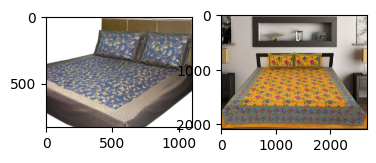

babycare
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/64d5d4a258243731dc7bbb1eef49ad74.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/90e56526f4c5892beac49f262b85150a.jpg


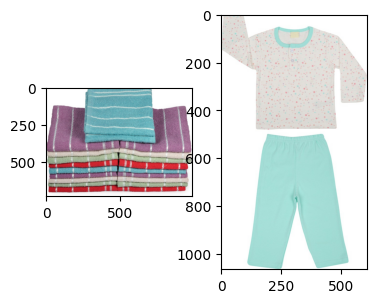

watches
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/f355cc1ccb08bd0d283ed979b7ee7515.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/dd0e3470a7e6ed76fd69c2da27721041.jpg


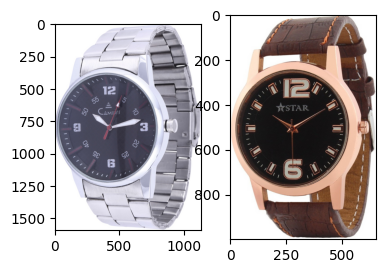

homedecorfestiveneeds
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/57578c1e6ec61a880a6f3f971f5f77b8.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/4e130ed339dcfe20d2c8b66892278a94.jpg


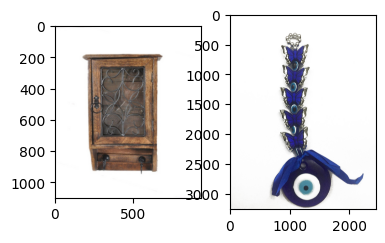

kitchendining
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/a3dea07b2f7bf48276d32513091be717.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/8050d31bffe6827c804b8222338aafb2.jpg


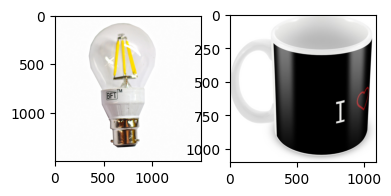

beautyandpersonalcare
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/02a53d335775b652f22f41b529b9d646.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/24e85c590481a7cedfe66597f253f2b2.jpg


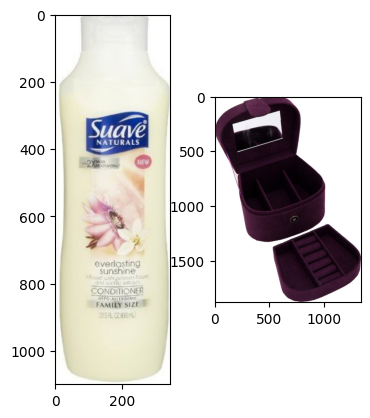

computers
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/b4d35b6536b623c83b293eb3a1c02bba.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/6329ddb46087cb8c09ced95471dd9643.jpg


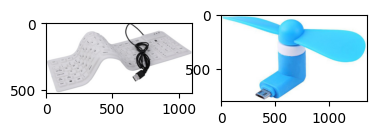

In [10]:

for name in df_clean['labels'].unique() :
    print(name)
    # print("-------")
    for i in range(1,3):
        plt.subplot(130 + 1 + i)
        filename = images_path+'/'+df_clean[df_clean['labels'] == name].iloc[i,1]
        print(filename)
        image = imread(filename)
        plt.imshow(image)
    plt.show()

Visualisons à présent l'effet du traitement de l'image :

homefurnishing
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/d4684dcdc759dd9cdf41504698d737d8.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/6325b6870c54cd47be6ebfbffa620ec7.jpg


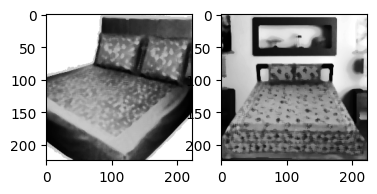

babycare
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/64d5d4a258243731dc7bbb1eef49ad74.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/90e56526f4c5892beac49f262b85150a.jpg


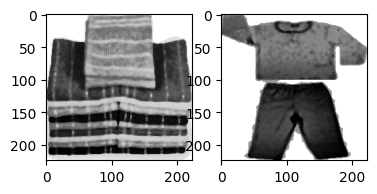

watches
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/f355cc1ccb08bd0d283ed979b7ee7515.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/dd0e3470a7e6ed76fd69c2da27721041.jpg


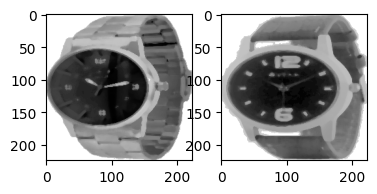

homedecorfestiveneeds
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/57578c1e6ec61a880a6f3f971f5f77b8.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/4e130ed339dcfe20d2c8b66892278a94.jpg


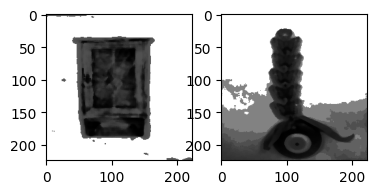

kitchendining
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/a3dea07b2f7bf48276d32513091be717.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/8050d31bffe6827c804b8222338aafb2.jpg


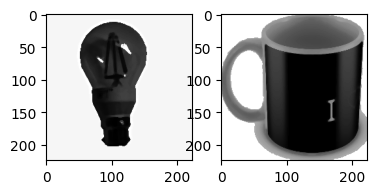

beautyandpersonalcare
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/02a53d335775b652f22f41b529b9d646.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/24e85c590481a7cedfe66597f253f2b2.jpg


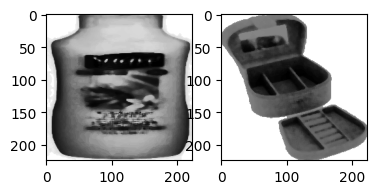

computers
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/b4d35b6536b623c83b293eb3a1c02bba.jpg
C:/Users/Cecil/Desktop/Formation/6_market/Flipkart/images/6329ddb46087cb8c09ced95471dd9643.jpg


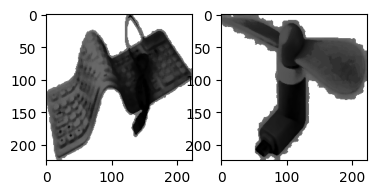

In [11]:
for name in df_clean['labels'].unique() :
    print(name)
    # print("-------")
    for i in range(1,3):
        plt.subplot(130 + 1 + i)
        filename = images_path+'/'+df_clean[df_clean['labels'] == name].iloc[i,1]
        print(filename)
        image = imread(filename)
        plt.imshow(preprocess_image(filename), cmap='gray')
    plt.show()

# Apprentissage non supervisé par extraction des features textuelles

In [12]:


df_clean['des_clean'] = df_clean['description'].map(preprocess_text)
 

Visualisons les mots les plus importants selon leurs scores tf-idf :

genuine: 0.05663254263979024
watch: 0.04092549539458219
analog: 0.03407397428914802
cm: 0.030903336856778676
set: 0.027572742984414676
mug: 0.02728740041763398
men: 0.02241830794822581
combo: 0.021681893032969378
price: 0.02122020149919253
baby: 0.0211892767550139
india: 0.0204081456589791
showpiece: 0.020099593682471998
cotton: 0.01935018448141674
best: 0.019060985200357875
woman: 0.01890451363953185
great: 0.018844775980467934
discount: 0.018549514813754175
girl: 0.017886643311890316
boy: 0.01619541326126058
ceramic: 0.01574185764980299


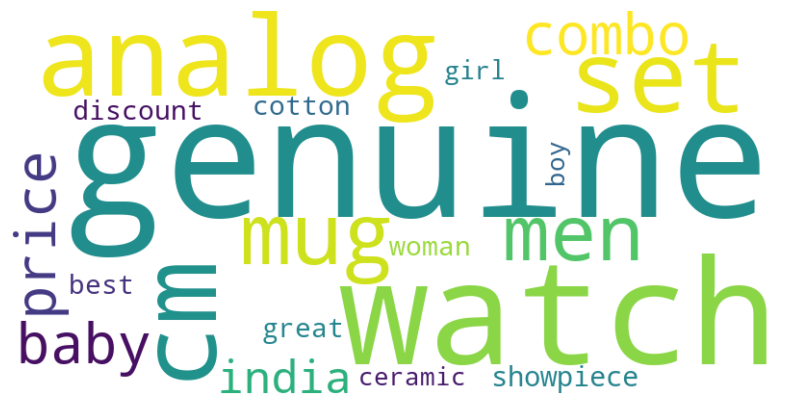

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


# Appeler la fonction et afficher les n mots les plus importants
top_words(df_clean['des_clean'], n=20)


Le nuage des mots met en évidence certains mots qui pourront être utiles pour la classification en catégorie comme : 
* watch pour la catégorie "montre" , 
* mug pour "kitchen", 
* baby pour "babycare", 
* cotton pour "homefurnishing"

Nous procédons à l'extraction des features avec :
* CountVectorizer : comptage simple des mots
* TfidfVectorizer : comptage des mots pondéré par leurs présences dans le corpus
* Word2Vec : caractérisation des mots par un vecteur (embeddings de mots), puis réalisation d'une moyenne vectorielle pour le texte complet
* Bert : modèle qui utilise l'apprentissage profond pour comprendre le contexte des mots dans une phrase en tenant compte des mots environnants à la fois à gauche et à droite
* Universal Sentence :  ce modèle moyenne les embeddings de mots et passe ces moyennes à travers plusieurs couches entièrement connectées pour obtenir les embeddings de phrase

In [14]:
features = {}
features = extract_textual_features(df_clean, 'description')
print(features)


Traitement bow en cours ...
18:09
1420
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly 

Traitement BERT en cours ...
18:09
0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
580 600
600 620
620 640
640 660
660 680
680 700
700 720
720 740
740 760
760 780
780 800
800 820
820 840
840 860
860 880
880 900
900 920
920 940
940 960
960 980
980 1000
1000 1020
1020 1040
1040 1060
{'bow_features': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 'tfidf_features': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'word2vec_features': array([[ 0.4219697 , -0.618

In [15]:
features

{'bow_features': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 'tfidf_features': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'word2vec_features': array([[ 0.4219697 , -0.6182825 , -0.24789211, ...,  1.1415256 ,
          0.8342685 , -1.1281605 ],
        [-1.1208819 ,  0.585571  , -1.2540895 , ..., -0.43443495,
          0.91978955, -1.1488594 ],
        [-0.04557781, -0.87448   , -0.7474157 , ...,  0.7011571 ,
          0.8355592 , -0.2589578 ],
        ...,
        [-0.38858595, -0.518167  ,  0.18212064, ...,  0.2948138 ,
         -0.29236272, -0.165431  ],
        [ 0.5544524 ,  0.4906591 ,  1.2220882 , .

Une fois les features stockées, nous réalisons une projection TSNE 2D pour visualiser les résultats. Nous calculons également un ARIscore entre les valeurs réelles et les valeurs prédites par un KMEAN sur les composantes du TSNE afin de chiffrer les similarités entre ces deux groupes.

-----------------------------------------
bow_features (1050, 4311)
Dimensions dataset avant réduction PCA :  (1050, 4311)
Dimensions dataset après réduction PCA :  (1050, 532)


C:\anaconda\envs\6_market\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


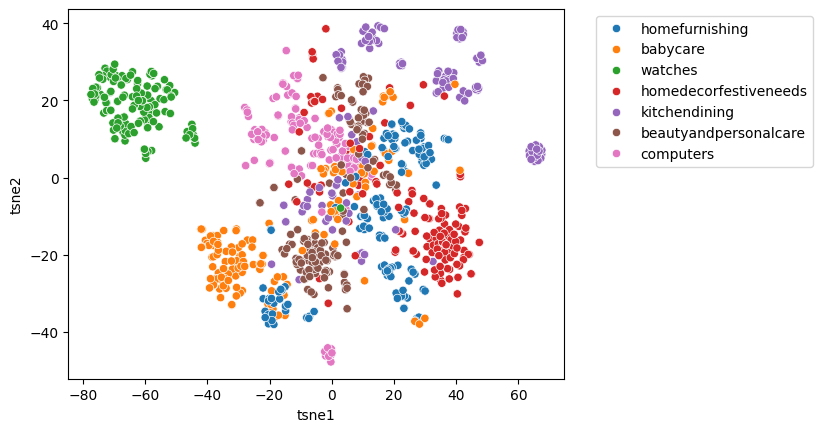

ARI : 0.3873686454545761
-----------------------------------------
tfidf_features (1050, 4311)
Dimensions dataset avant réduction PCA :  (1050, 4311)
Dimensions dataset après réduction PCA :  (1050, 773)


C:\anaconda\envs\6_market\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


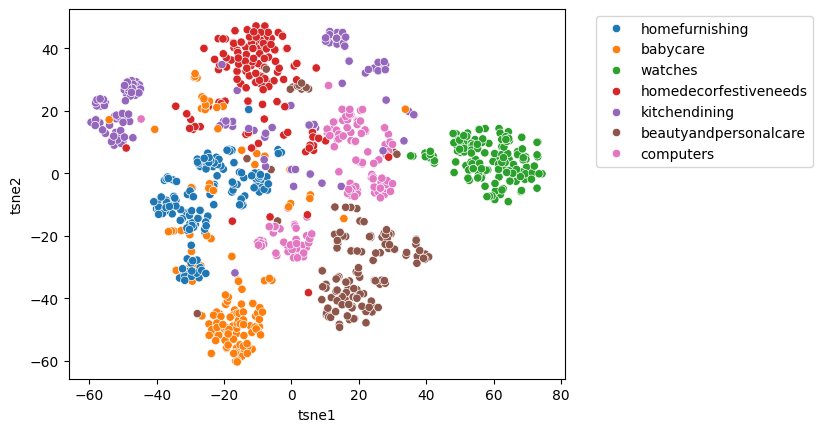

ARI : 0.5655287673634936
-----------------------------------------
word2vec_features (1050, 500)
Dimensions dataset avant réduction PCA :  (1050, 500)
Dimensions dataset après réduction PCA :  (1050, 6)


C:\anaconda\envs\6_market\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


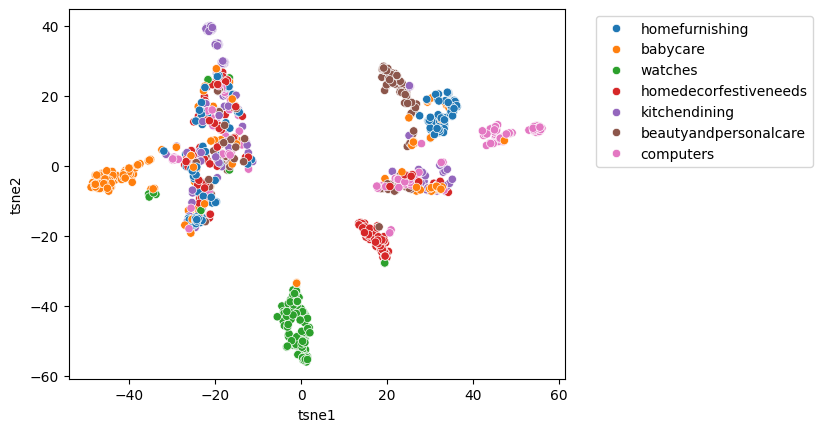

ARI : 0.24899005140598426
-----------------------------------------
use_features (1050, 512)
Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 308)


C:\anaconda\envs\6_market\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


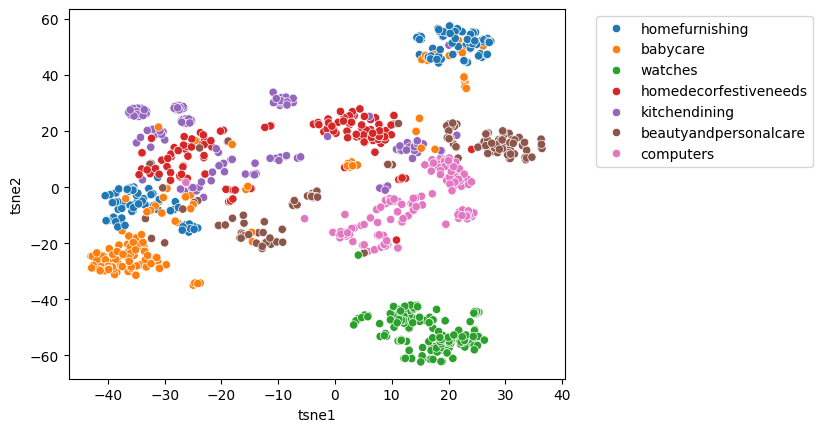

ARI : 0.4411434480750551
-----------------------------------------
bert_features (1050, 768)
Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 263)


C:\anaconda\envs\6_market\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


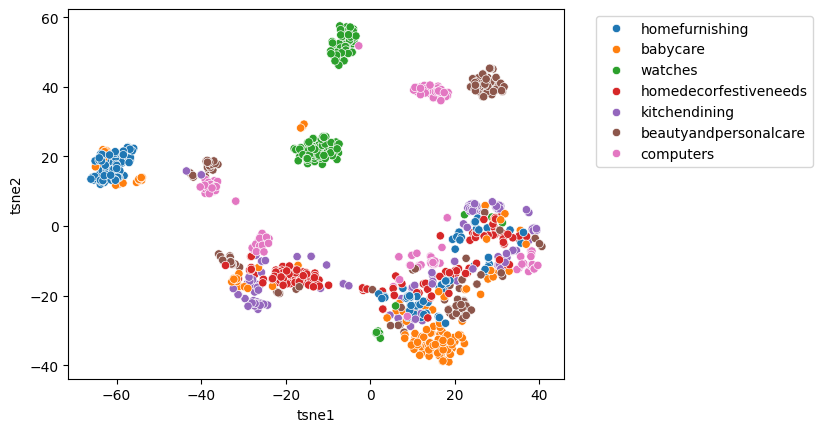

ARI : 0.185683531547025


In [16]:
for f in features : 
    print('-----------------------------------------')
    
    print(f,features[f].shape)
    visu_TSNE(features[f], df_clean["labels"])

# Apprentissage non supervisé par extraction des features images

## Extraction features images : Méthode SIFT
Nous allons récupérer les features par l'algorythme SIFT :
1. **Détection de points d'intérêt** :
   - SIFT identifie les points clés dans une image en recherchant des régions distinctes comme des coins ou des intersections.
   

2. **Échantillonnage des échelles** :
   - SIFT crée une pyramide d'images floutées pour détecter les points d'intérêt à différentes échelles.

3. **Détermination de l'échelle dominante** :
   - Pour chaque point d'intérêt détecté, SIFT détermine l'échelle à laquelle le descripteur est le plus stable.

4. **Calcul des descripteurs locaux** :
   - SIFT crée des descripteurs basés sur la distribution des gradients dans les régions entourant chaque point d'intérêt.

5. **Normalisation des descripteurs** :
   - Les descripteurs SIFT sont normalisés pour réduire l'impact des variations locales de contraste.
   
6. **Clusterisation des descripteurs** :
   - Les clusters de descripteurs permettent de regrouper l'ensemble des descripteurs en un nombre restreint de groupe.
   
6. **Réalisation des histogrammes** :
   - Les histogrammes sont constitués par la somme des descripteurs contenus dans chaque clusters. Les images ont dès lors des "features" qui leurs sont propres et chaque image possède un vecteur d'histogramme unique fonction des descripteurs.

(337, 128)
55b85ea15a1536d46b7190ad6fff8ce7.jpg
(204, 128)
7b72c92c2f6c40268628ec5f14c6d590.jpg
(383, 128)
64d5d4a258243731dc7bbb1eef49ad74.jpg
(342, 128)
d4684dcdc759dd9cdf41504698d737d8.jpg
(530, 128)
6325b6870c54cd47be6ebfbffa620ec7.jpg
(320, 128)
893aa5ed55f7cff2eccea7758d7a86bd.jpg
(200, 128)
f355cc1ccb08bd0d283ed979b7ee7515.jpg
(166, 128)
dd0e3470a7e6ed76fd69c2da27721041.jpg
(192, 128)
41384da51732c0b4df3de8f395714fbb.jpg
(271, 128)
710ed5f2393a4b9e8823aa0029f71f93.jpg
Temps de traitement SIFT descriptor : 60.60 secondes
Nombre de descripteurs :  (239719, 128)
Création de 1000 clusters de descripteurs ...
temps de traitement kmeans :           113.48 secondes
0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.15 secondes
Dimensions dataset avant réduction PCA :  (1050, 1000)
Dimensions dataset après réduction PCA :  (1050, 692)


C:\anaconda\envs\6_market\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


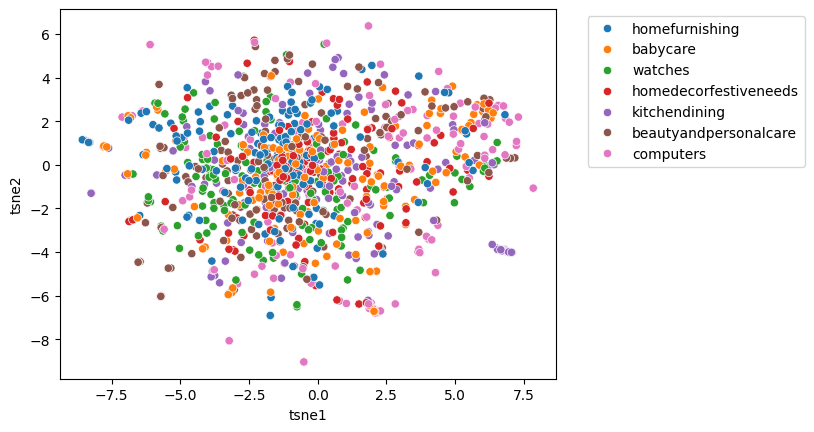

ARI : 0.028464870883663146


In [22]:


sift_features = sift_feat(df_clean['images'])


## Extraction des features des images : Transfer learning
A présent nous allons récupérer les features générées par un modèle pré-entrainé par un groupe de recherche en géométrie d'oxford VGG16 :
   * 1. utilisation des poids de la base de données d'entrainement imagenet
   * 2. suppression de la couche fully connected de classification
   * 3. Predict() pour récupérer les features observées par le modèle
   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━

(1050, 512)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 343)


C:\anaconda\envs\6_market\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


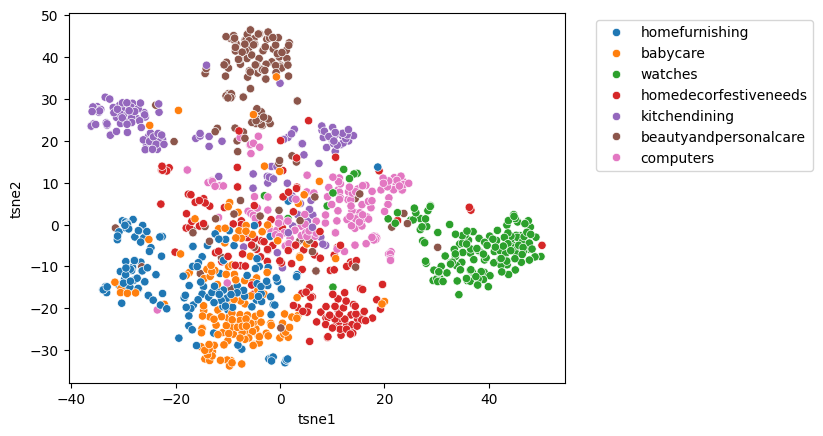

ARI : 0.426642214840682


array([[0.        , 0.63156784, 0.        , ..., 0.2321799 , 0.        ,
        0.89109266],
       [0.78469425, 0.        , 0.        , ..., 3.0973432 , 3.9063215 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07526363,
        0.05503048],
       ...,
       [0.29133514, 0.3790742 , 0.        , ..., 0.        , 1.5626909 ,
        0.85410494],
       [2.4457195 , 0.        , 0.41265157, ..., 1.1859137 , 3.483037  ,
        0.634121  ],
       [1.3206117 , 0.2507458 , 1.4091588 , ..., 0.09139551, 1.2963948 ,
        0.        ]], dtype=float32)

In [23]:
vgg16_feat(df_clean['images'])

L'extraction des features images par transfer learning permet de valider la faisabilité d'une classification automatisée d'objet. Le score ARI correspondant est de 0.42.